In [1]:
import tensorflow as tf
import shutil
import json 
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg

In [2]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

In [8]:

# Opening JSON file 
f = open('archive/mmimdb/split.json') 
data = json.load(f) 
f.close() 
devel=np.array(data['dev'])
test=np.array(data['test']) 
train=np.array(data['train'])

In [9]:
devel.size, test.size, train.size

(1992, 1996, 2999)

In [10]:
df_train=pd.DataFrame(columns=['label','File_name','Plot','label_encode'],index=train)
for i in train:
  f = open('archive/mmimdb//dataset/'+i+'.json') 
  df_train.File_name[i]=i+'.jpeg'
  data2 = json.load(f)
  f.close()  
  for u in [ 'News','Reality-TV', 'Talk-Show','Adult']:
    if u in data2['genres']:
      data2['genres'].remove(u)
  df_train.label[i]=data2['genres']
  df_train.Plot[i]=data2['plot']

df_val=pd.DataFrame(columns=['label','File_name','Plot','label_encode'],index=devel)
for i in devel:
  f = open('archive/mmimdb/dataset/'+i+'.json') 
  df_val.File_name[i]=i+'.jpeg'
  data2 = json.load(f)
  f.close()
  for u in [ 'News','Reality-TV', 'Talk-Show','Adult']:
    if u in data2['genres']:
      data2['genres'].remove(u)
  df_val.label[i]=data2['genres']
  df_val.Plot[i]=data2['plot']



df_test=pd.DataFrame(columns=['label','File_name','Plot','label_encode'],index=test)
for i in test:
  f = open('archive/mmimdb/dataset/'+i+'.json') 
  df_test.File_name[i]=i+'.jpeg'
  data2 = json.load(f)
  f.close()
  for u in [ 'News','Reality-TV', 'Talk-Show','Adult']:
    if u in data2['genres']:
      data2['genres'].remove(u)
  df_test.label[i]=data2['genres']
  df_test.Plot[i]=data2['plot']

In [11]:
mlb = MultiLabelBinarizer()
mlb.fit(df_train.label)
y_train_bin = mlb.transform(df_train.label)
y_train_bin
mlb.classes_
np.shape(y_train_bin)
y_train_bin[0,:]
for u in range(len(df_train)):
  df_train['label_encode'][train[u]]=y_train_bin[u,:]

In [12]:
mlb = MultiLabelBinarizer()
mlb.fit(df_train.label)
y_test_bin = mlb.transform(df_test.label)
for u in range(len(df_test)):
  df_test['label_encode'][test[u]]=list(y_test_bin[u,:])

In [13]:
mlb = MultiLabelBinarizer()
mlb.fit(df_train.label)
y_val_bin = mlb.transform(df_val.label)
for u in range(len(df_val)):
  df_val['label_encode'][devel[u]]=y_val_bin[u,:]

In [14]:
img_width, img_height = 224, 224
data_dir = 'archive/mmimdb/dataset/'
nb_train_samples = len(train)#15552
nb_validation_samples = len(devel)#2608
epochs = 15
batch_size = 12
#class_weight=1-(y_train_bin.sum(axis=0)/y_train_bin.sum()) #to deal with the unbalance dataset
class_weight = {}
temp_weight = 1 - (y_train_bin.sum(axis=0) / y_train_bin.sum())
for i in range (len(temp_weight)):
    class_weight[i] = temp_weight[i]

In [15]:
image_data_generator = ImageDataGenerator(
    validation_split=0,
    rescale=1. / 255)
train_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=data_dir,
    x_col='File_name',
    y_col='label' ,
    class_mode='categorical',
    target_size=(img_width, img_height ),
    batch_size=batch_size,shuffle=False 
)
validation_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_val,
    directory=data_dir,
    x_col='File_name',
    y_col='label',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size,shuffle=False  
)

test_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=data_dir,
    x_col='File_name',
    y_col='label',
    class_mode='categorical',#multi_output
    target_size=(img_width, img_height),
    batch_size=batch_size,shuffle=False  
)

Found 2999 validated image filenames belonging to 23 classes.
Found 1992 validated image filenames belonging to 23 classes.
Found 1996 validated image filenames belonging to 23 classes.


In [16]:
extractor = MobileNet(weights='imagenet', include_top=False,
                                            input_shape=(img_width, img_height, 3))
pool = keras.layers.GlobalAveragePooling2D()(extractor.output)
dense1 = keras.layers.Dense(32, activation="relu")(pool)
drop1 = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(23, activation="sigmoid")(drop1)
t2_model = keras.models.Model(inputs=[extractor.input], outputs=[dense2])

In [48]:
# Unfreeze the extractor layers
for layer in t2_model.layers[-23:]:
    layer.trainable = True

# Learning rate
t2_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-5),
                 metrics=[tf.keras.metrics.CategoricalAccuracy() ])#'acuracy' macro_f1

# train

t2_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,class_weight=class_weight)

Epoch 1/15
249/249 [==============================] - 431s 2s/step - loss: 0.6155 - categorical_accuracy: 0.0636 - val_loss: 0.6199 - val_categorical_accuracy: 0.0994
Epoch 2/15
249/249 [==============================] - 400s 2s/step - loss: 0.5043 - categorical_accuracy: 0.1071 - val_loss: 0.5177 - val_categorical_accuracy: 0.1255
Epoch 3/15
249/249 [==============================] - 429s 2s/step - loss: 0.4598 - categorical_accuracy: 0.1209 - val_loss: 0.4647 - val_categorical_accuracy: 0.1365
Epoch 4/15
249/249 [==============================] - 424s 2s/step - loss: 0.4339 - categorical_accuracy: 0.1503 - val_loss: 0.4370 - val_categorical_accuracy: 0.1642
Epoch 5/15
249/249 [==============================] - 427s 2s/step - loss: 0.4128 - categorical_accuracy: 0.1738 - val_loss: 0.4146 - val_categorical_accuracy: 0.1647
Epoch 6/15
249/249 [==============================] - 423s 2s/step - loss: 0.3951 - categorical_accuracy: 0.1922 - val_loss: 0.3966 - val_categorical_accuracy: 0.199

In [49]:
t2_model.save('1_FT.h5')

In [50]:
#prediction of test set
predic2 = t2_model.predict(test_generator)
#y_pred2=bina(predic2,0.5)
score2=f1_score(y_test_bin,y_pred2,average='micro')
score2b=f1_score(y_test_bin,y_pred2,average='macro')

NameError: name 'bina' is not defined

In [53]:

#Preprocessing
ims = [keras.preprocessing.image.load_img(i, target_size=(224, 224, 3))\
       for i in ['archive/mmimdb/dataset/'+test[10]+'.jpeg','archive/mmimdb/dataset/'+test[20]+'.jpeg','archive/mmimdb/dataset/'+test[30]+'.jpeg','archive/mmimdb/dataset/'+test[40]+'.jpeg']]
ims = np.array(list(map(np.array, ims)))
ims_prep = keras.applications.mobilenet.preprocess_input(ims.copy())

In [54]:
df_test.label[[test[10],test[20],test[30],test[40]]]

0023369                                [Drama]
1722450               [Comedy, Drama, Romance]
0386117    [Adventure, Drama, Family, Fantasy]
0071877                [Crime, Drama, Mystery]
Name: label, dtype: object

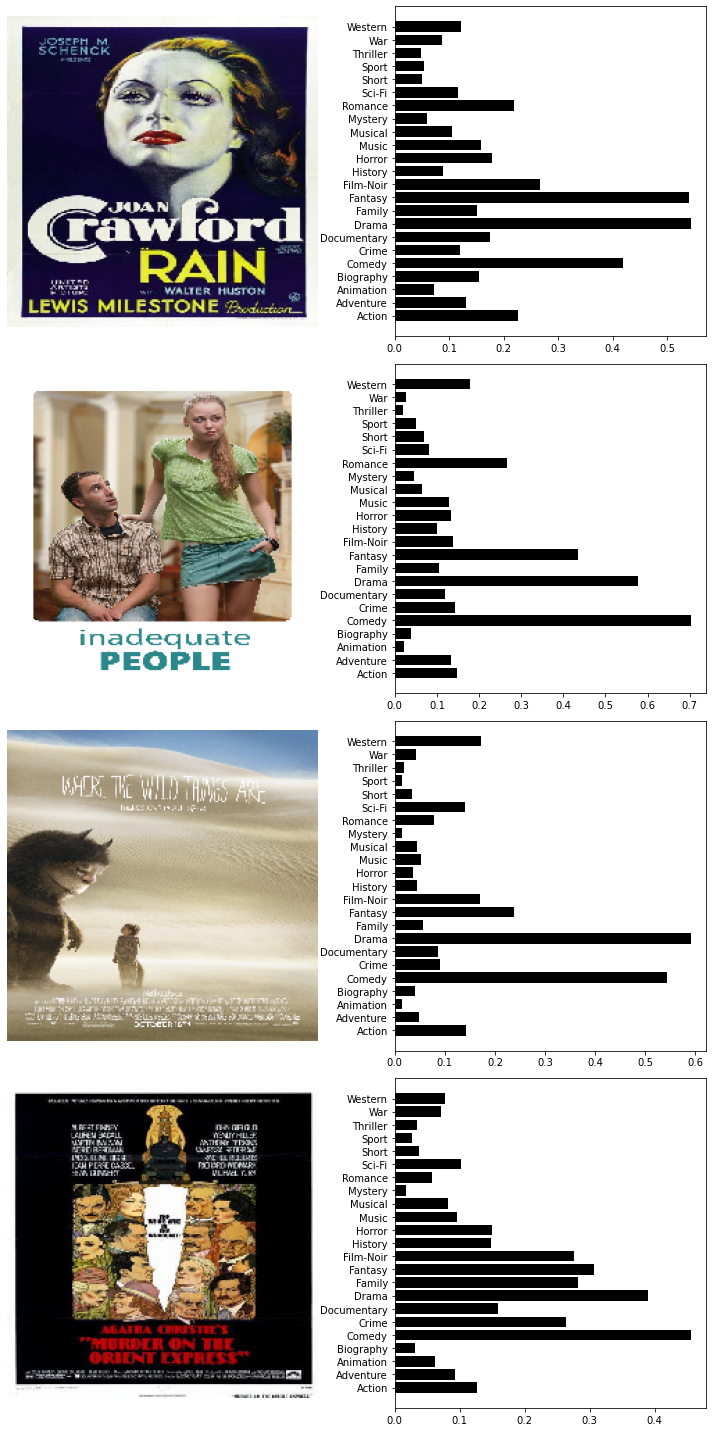

In [55]:
# obtenemos las predicciones
preds = t2_model.predict(ims_prep)
labs = mlb.classes_
fig, ax = plt.subplots(4, 2, figsize=(10,20))
for i in range(4):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].barh(labs,preds[i], color="k")
fig.tight_layout()

In [3]:
from keras.models import load_model

In [17]:
new_model = tf.keras.models.load_model('movie_poster.h5')

In [18]:
#GAMES COVERS (AND GALLY)

#Preprocessing
ims = [keras.preprocessing.image.load_img(i, target_size=(224, 224, 3))\
       for i in ['archive/mmimdb/games/azura_1.jpg','archive/mmimdb/games/azura_2.jpg','archive/mmimdb/games/calista.jpg','archive/mmimdb/games/gally.jpg','archive/mmimdb/games/velvet.jpg','archive/mmimdb/games/gta.jpeg','archive/mmimdb/games/cod.jpg']]
ims = np.array(list(map(np.array, ims)))
ims_prep = keras.applications.mobilenet.preprocess_input(ims.copy())

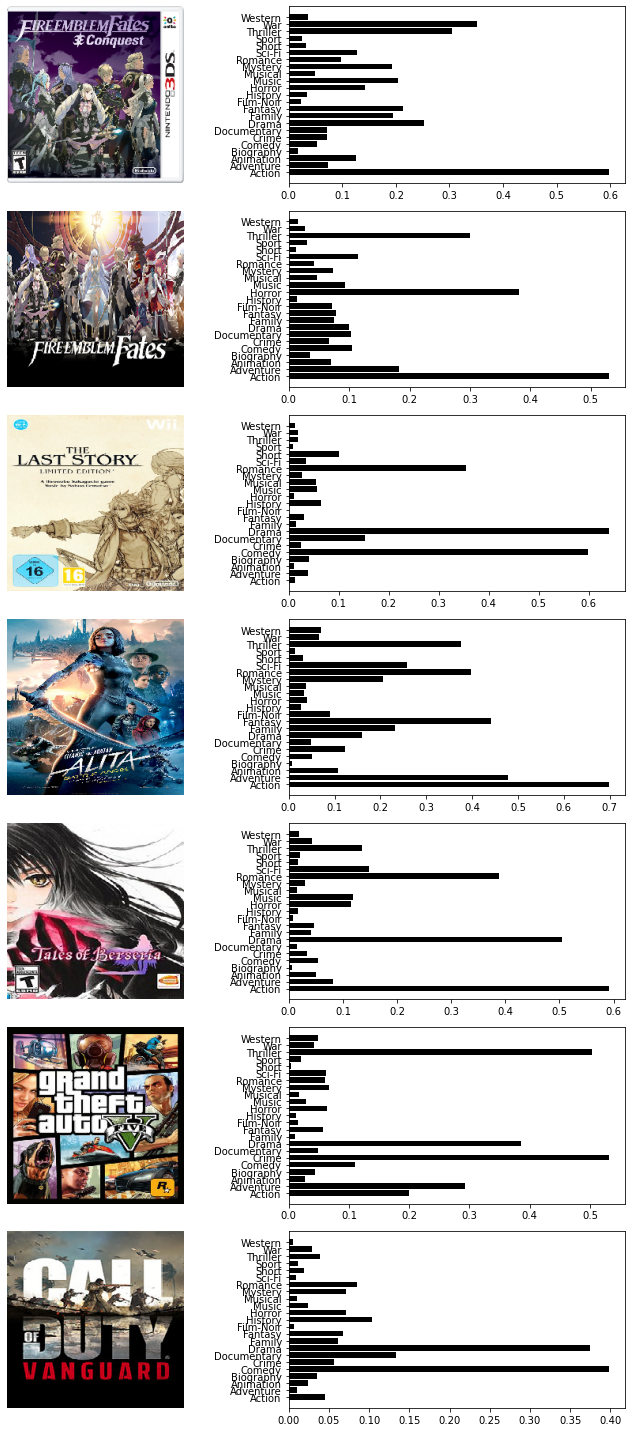

In [22]:
# obtenemos las predicciones
preds = new_model.predict(ims_prep)
labs = mlb.classes_
fig, ax = plt.subplots(7, 2, figsize=(10,20))
for i in range(7):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].barh(labs,preds[i], color="k")
fig.tight_layout()